# Nowcasting American GDP Growth using a Neural Network

In this project, a Long Short-Term Memory (LSTM) model is trained to predict the growth in American GDP onesubsequent quarter at a time. 


In [1]:
import pandas as pd
import os
from functools import reduce

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from numpy.random import seed
seed(42)

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

Using TensorFlow backend.
C:\Users\Otto\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Otto\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Otto\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Otto\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

## Import Data

The data used is retrieved from the [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/). The variables included in the analysis are:

* Real GDP - GDPC1
* Industrial Production Index - INDPRO
* Real Disposable Personal Income - DPIC96
* Unemployment Rate - UNRATE
* All Employees, Total Nonfarm - PAYEMS
* Personal Consumption Expenditures - PCEC
* Producer Price Index by Commodity: All Commodities - PPIACO
* Consumer Price Index for All Urban Consumers: All Items in U.S. City Average - CPIAUCSL
* Real imports of goods and services - IMPGSC1
* Real Exports of Goods and Services - EXPGSC1


In [2]:
%%capture
cwd = os.getcwd() 
data_folder = cwd + r'\Desktop\neural\data_nowcast'

var_lst = ['GDPC1', 'INDPRO', 'DPIC96', 'UNRATE', 'PAYEMS', 'PCEC', 'PPIACO', 'CPIAUCSL', 'IMPGSC1', 'EXPGSC1']

df_lst = []

def load_data(file):
    ''' Load data and store it in a list of dataframes '''
    df_in = pd.read_csv(data_folder + r'\{}.csv'.format(file))
    df_lst.append(df_in)

[load_data(file) for file in var_lst]

About halft of the data series above are given on a monthly basis and the remaining on a quaterly basis. These are merged together below resulting in quaterly data. The first two quarters of 2020 are dropped to exclude the quite violent effects COVID-19 has had on the economy.

In [3]:
df = reduce(lambda left, right: pd.merge(left, right, on = 'DATE'), df_lst)

df.set_index('DATE', inplace = True)
df.dropna(inplace = True)

df = df.iloc[90:-2, :]

## Visualize Data

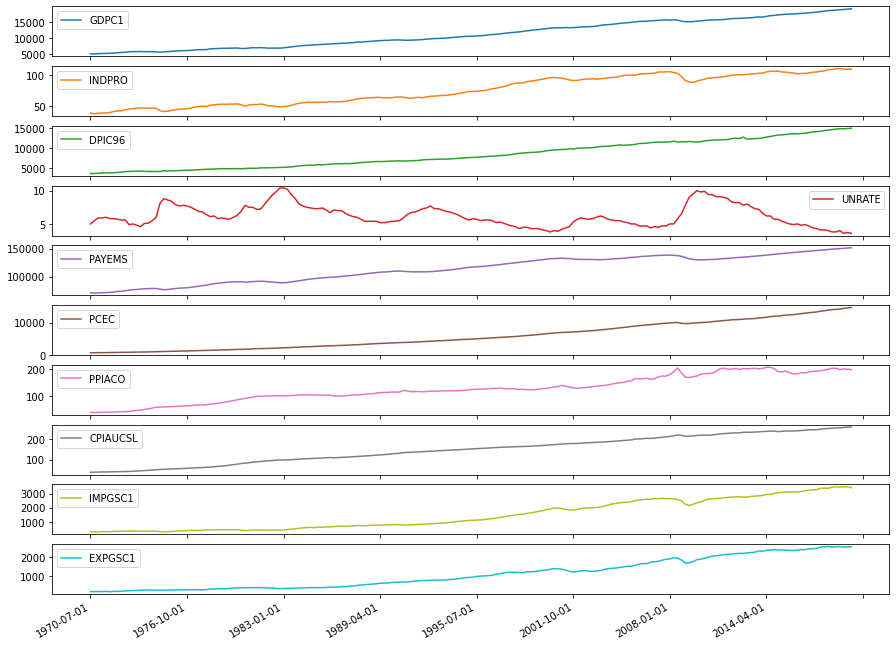

In [4]:
df.plot(subplots = True, figsize = (15, 12))
plt.xlabel('')
plt.show()

### Log transform and first difference


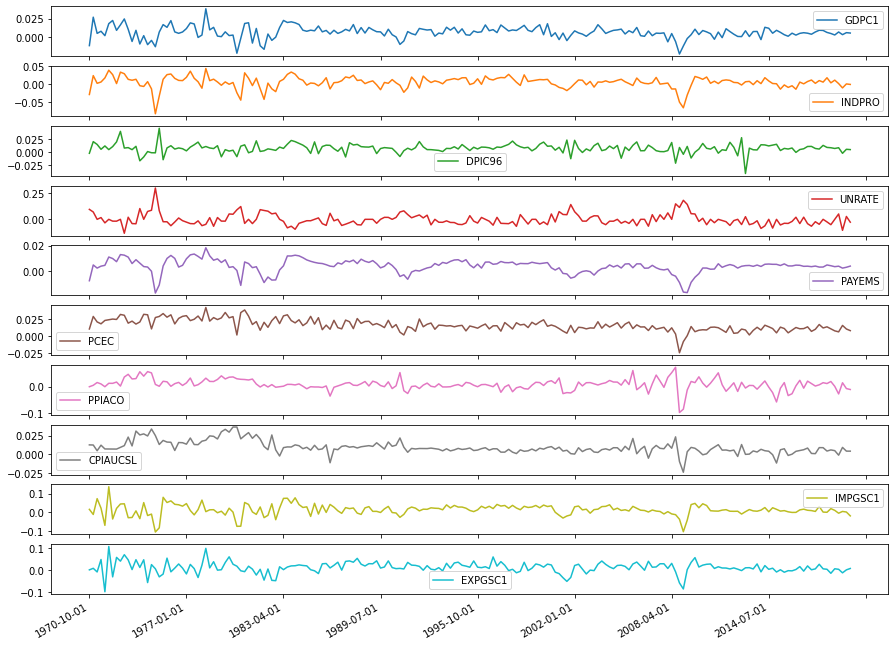

In [5]:
df_log  = np.log(df)
df_diff = df_log.diff().iloc[1:,:]
df_diff.plot(subplots = True, figsize = (15, 12))

plt.xlabel('')
plt.show()

## Prepare Data for Network

Scale data to the [0,1] range.

In [6]:
scaler = MinMaxScaler(feature_range = (0, 1))
data_scaled = scaler.fit_transform(df_diff)

Generate lags of all variables.

In [7]:
scaled_df = pd.DataFrame(data_scaled)

scaled_df.columns = df.columns

scaled_df.set_index

scaled_df['index'] = scaled_df.index
Y = scaled_df[['index', 'GDPC1']].iloc[1:]


scaled_df = scaled_df.add_suffix('(t-1)')

# Adjust the index of Y
Y['index'] = Y['index'] -1
Y = Y.add_suffix('(t)')


reframed = scaled_df.merge(Y, how = 'inner', left_on= 'index(t-1)', right_on='index(t)')
reframed.drop(['index(t-1)', 'index(t)'], axis = 'columns', inplace= True)

reframed.head()

,GDPC1(t-1),INDPRO(t-1),DPIC96(t-1),UNRATE(t-1),PAYEMS(t-1),PCEC(t-1),PPIACO(t-1),CPIAUCSL(t-1),IMPGSC1(t-1),EXPGSC1(t-1),GDPC1(t)
0,0.185672,0.425704,0.446768,0.527727,0.271270,0.525325,0.569650,0.604632,0.500229,0.483717,0.814067
1,0.814067,0.842913,0.704185,0.469831,0.619894,0.801975,0.601045,0.601955,0.387715,0.518043,0.456131
2,0.456131,0.672848,0.642602,0.307934,0.550742,0.681387,0.662836,0.475454,0.737008,0.437305,0.502955
3,0.502955,0.702113,0.535154,0.346693,0.593251,0.639423,0.630958,0.598318,0.526975,0.712100,0.405261
4,0.405261,0.791660,0.609286,0.229755,0.611691,0.714097,0.569650,0.514715,0.146829,0.000000,0.670647


Convert data into training and testing samples, consisting of 80% and 20%, respectively. 

In [8]:
train_len = round(0.8 * len(df))
train     = reframed.iloc[:train_len, :]
test      = reframed.iloc[train_len:, :]

train_X = train.iloc[:, :-1] 
train_y = train.iloc[:, -1]
test_X  = test.iloc[:, :-1]
test_y  = test.iloc[:, -1]

train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X  = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))

## Analysis
### Design Network

In [9]:
# Parameters
n_lyrs   = 100
n_epochs = 200
b_size   = 100

# Specify model
model = Sequential()
model.add(LSTM(n_lyrs, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(n_lyrs))

model.add(Dense(1)) 
model.compile(loss='mae', optimizer='adam')

### Fit the model

In [10]:
history = model.fit(train_X, 
                    train_y, 
                    epochs = n_epochs, 
                    batch_size = b_size,
                    validation_split = 0.5,
                    verbose = 2, 
                    shuffle = False)


Train on 79 samples, validate on 79 samples
Epoch 1/200
 - 0s - loss: 0.5926 - val_loss: 0.4915
Epoch 2/200
 - 0s - loss: 0.5255 - val_loss: 0.4300
Epoch 3/200
 - 0s - loss: 0.4594 - val_loss: 0.3690
Epoch 4/200
 - 0s - loss: 0.3945 - val_loss: 0.3074
Epoch 5/200
 - 0s - loss: 0.3311 - val_loss: 0.2478
Epoch 6/200
 - 0s - loss: 0.2749 - val_loss: 0.1879
Epoch 7/200
 - 0s - loss: 0.2199 - val_loss: 0.1330
Epoch 8/200
 - 0s - loss: 0.1688 - val_loss: 0.0855
Epoch 9/200
 - 0s - loss: 0.1350 - val_loss: 0.0703
Epoch 10/200
 - 0s - loss: 0.1261 - val_loss: 0.0968
Epoch 11/200
 - 0s - loss: 0.1404 - val_loss: 0.1282
Epoch 12/200
 - 0s - loss: 0.1641 - val_loss: 0.1493
Epoch 13/200
 - 0s - loss: 0.1815 - val_loss: 0.1559
Epoch 14/200
 - 0s - loss: 0.1867 - val_loss: 0.1498
Epoch 15/200
 - 0s - loss: 0.1814 - val_loss: 0.1348
Epoch 16/200
 - 0s - loss: 0.1689 - val_loss: 0.1154
Epoch 17/200
 - 0s - loss: 0.1533 - val_loss: 0.0960
Epoch 18/200
 - 0s - loss: 0.1390 - val_loss: 0.0789
Epoch 19/2

### Plot Model Training History 

The plot below shows the loss for the training and validation datasets during the training process of the model. As can be seen, the performance is similar for both the training and validation sets, indicating that we neither have too much over- nor underfitting.  

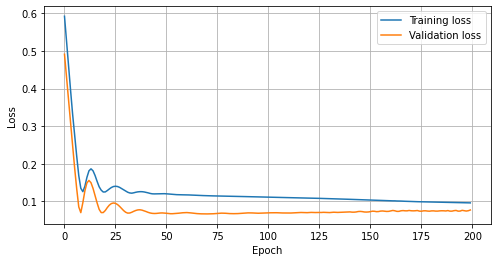

In [11]:
plt.figure(figsize = (8, 4))

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.show()

### Generate a Pridiction and Calculate RMSE

In this step, predictions are made using the test sample and the model trained above. 

In [12]:
# Generate prediction using test data and model trained above 
yhat     = model.predict(test_X)
test_X   = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert the scaling for the predictions
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis = 1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert the scaling for the actual data
test_y   = test_y.values.reshape((len(test_y), 1))
inv_y    = np.concatenate((test_y, test_X[:, 1:]), axis = 1)
inv_y    = scaler.inverse_transform(inv_y)
inv_y    = inv_y[:,0]

# Calculate the RMSE for the prediction 
rmse     = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: \n %.3f' % rmse)

Test RMSE: 
 0.005


## Visualize Predicted vs Actual Growth

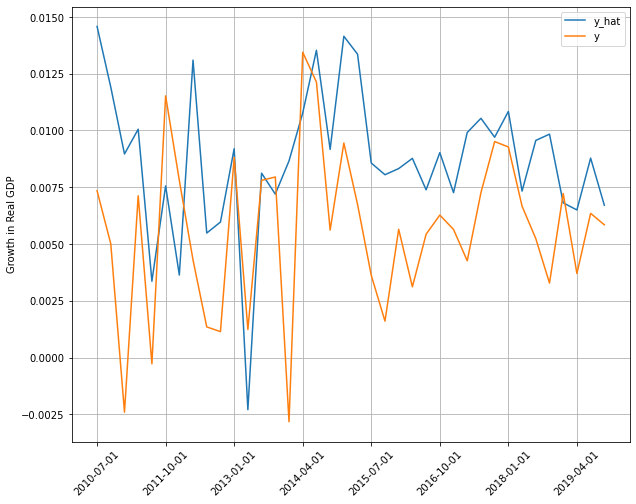

In [13]:
# Generate a dataframe with the predictions and actual values
y = np.concatenate((inv_yhat[:, np.newaxis], inv_y[:, np.newaxis]), axis = 1)
y_df = pd.DataFrame(y, columns= ['y_hat', 'y'])
y_df.index = df_log.index[-len(inv_yhat):]

y_df.plot(rot = 45, figsize = (10, 8))
plt.xlabel('')
plt.ylabel('Growth in Real GDP')
plt.grid()
plt.show()

Based on the figure above, the predictions are far from perfect. In several cases the model does a fairly good job of predictiong the changes in GDP. In other cases, however, the models instead predicts movements in the opposite direction of actual GDP.

## Predict GDP

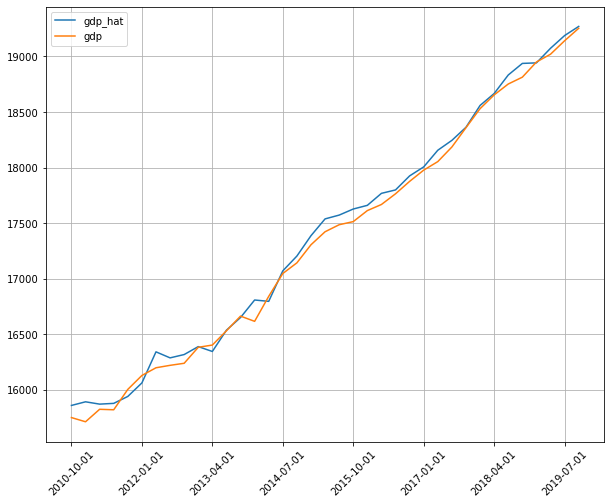

Mean Absolute Error: 
 65.146


In [14]:
# Generate array with the logged GDP values
log_arr = df_log.iloc[-len(inv_yhat):, 0].values

# Add predictions and empty columns
log_arr = np.concatenate((log_arr[:, np.newaxis], y), axis = 1)
log_arr = np.concatenate((log_arr, np.zeros([log_arr.shape[0], 2])), axis = 1)

for i in range(0, log_arr.shape[0]-1):
    # Add the predicted changes to the logged GDP values
    log_arr[i+1, 4] = log_arr[i+1, 2] + log_arr[i, 0]
    log_arr[i+1, 3] = log_arr[i+1, 1] + log_arr[i, 0]

# Invert the log
out_arr = np.exp(log_arr)

# Generate a dataframe with the final predictions
out_df = pd.DataFrame(out_arr[:, 3:5], columns = ['gdp_hat', 'gdp'])
ix = df_log.index[-len(inv_yhat):]
out_df.index = df_log.index[-len(inv_yhat):]
out_df = out_df.iloc[1:, :]


out_df.plot(rot = 45, figsize = (10, 8))
plt.xlabel('')
plt.grid()
plt.show()

# Calculate mean absolute error
mae = mean_absolute_error(out_df['gdp'].values, out_df['gdp_hat'].values)

print('Mean Absolute Error: \n %.3f' % mae)